Recently I added some alternative correlations to [GasDispersion.jl](https://github.com/aefarrell/GasDispersion.jl), the julia package I put together for basic chemical release modeling, and I thought it would be worthwhile to circle back and look at some of those in more depth.

Typically, when evaluating various release scenarios, key pieces of the model are specified in advance and each scenario uses the same set of assumptions: comparing apples to apples. For a Gaussian plume dispersion model there are really three key correlations used for the model parameters: the wind-speed profile, crosswind dispersion, and vertical dispersion. Correlations for each of these are given in the standard references and there is not, to my mind, any deep reason to prefer one reference over the another. Besides maintaining consistency with other modeling or perhaps with industry practice in a particular area.

This raises the obvious question: how much does it matter which reference you use? Usually one takes the results of a Gaussian plume model with a fair grain of salt, these are "order of magnitude" estimates really. That's what I'm going to look at here.

In [2]:
#| echo: false

using Plots, LaTeXStrings, Measures
using GasDispersion

colours = palette(:Paired_8);

In [3]:
#| echo: false

sets = [ (name="Default", eqn=DefaultSet, color=:black, linestyle=:solid, lw=3),
         (name="CCPS Rural", eqn=CCPSRural, color=colours[2], linestyle=:solid, lw=3),
         (name="CCPS Urban", eqn=CCPSUrban, color=colours[4], linestyle=:solid, lw=3),
         (name="ISC3 Rural", eqn=ISC3Rural, color=colours[1], linestyle=:dash, lw=2),
         (name="ISC3 Urban", eqn=ISC3Urban, color=colours[3], linestyle=:dash, lw=2),
         (name="TNO", eqn=TNO, color=colours[6], linestyle=:dash, lw=2),
         (name="Turner", eqn=Turner, color=colours[7], linestyle=:dash, lw=2) ];

## Windspeed

The windspeed correlations I am looking at here are the basic power law

$$ u = u_R \left( z \over z_R \right)^p $$

where *u<sub>R</sub>* is the known windspeed at a reference height *z<sub>R</sub>* and *p* is a parameter that depends upon the [Pasquill stability class](https://en.wikipedia.org/wiki/Outline_of_air_pollution_dispersion#The_Pasquill_atmospheric_stability_classes). There are more complex models that incorporate the surface roughness, Monin-Obukhov mixing length, and other measures of stability, they are beyond this analysis.

There are three different standard references used in `GasDispersion.jl` for windspeed: the default which comes from @spicer-1989, the correlations used by the EPA Industrial Source Complex (ISC3)[@epa-1995] dispersion models, and the correlations given in the various CCPS guidance documents[@ccps-1999]

The ISC3 and CCPS correlations are divided into urban and rural terrain and are exactly the same correlations for the unstable classes. They appear to be the correlations given in @hanna-1982. They also bracket the default correlation. Clearly whether or not the terrain is urban is significant, it can lead to a 20-30% difference in estimated windspeed (depending upon elevation).

In [4]:
#| echo: false

u0, z0 = 1.0, 1.0

xs = range(1.0,10.0,100)

function plot_windspeed!(plt,class)
    plot!(plt, xlabel=L"z/z_R", ylabel=L"u/u_R", title="$class", legend=false)

    for s in sets[1:5]
        ys = [ GasDispersion._windspeed(u0,z0,x,class,s.eqn) for x in xs]
        plot!(plt,xs,ys, color=s.color, linestyle=s.linestyle, lw=s.lw, label=s.name)
    end

end

ws_legend = plot(framestyle=:none, legend=:topleft, foreground_color_legend = nothing);

for s in sets[1:5]
    plot!(ws_legend,(1), color=s.color, linestyle=:solid, lw=2, label=s.name);
end

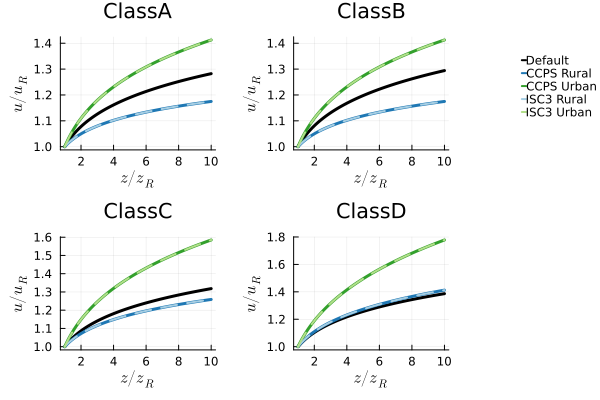

In [5]:
#| echo: false
#| label: fig-1
#| fig-cap: "Windspeed correlations for class A, B, C, and D stability."

wsA, wsB, wsC, wsD = plot(), plot(), plot(), plot()

plot_windspeed!(wsA,ClassA)
plot_windspeed!(wsB,ClassB)
plot_windspeed!(wsC,ClassC)
plot_windspeed!(wsD,ClassD)

l1 = @layout [ grid(2,2) b{0.14w} ]

plot(wsA, wsB, wsC, wsD, ws_legend, layout=l1, size=(600,400), margin=2.5mm)

For the stable atmospheres the ISC3 and CCPS *rural* correlations are the same. However they are very different for *urban* terrain and they no longer bracket the default correlation. The CCPS *urban* correlations are the same as Hanna, Briggs, and Hosker[@hanna-1982], the ISC3 correlations use the parameter *p* = 0.30 and no reference is given in the model specification so I don't know why.

For an urban release scenario, whether or not one choses the default, the ISC3 urban, or the CCPS urban correlation can lead to a 300% difference in windspeed (for class F stability, depending on elevation). Which is a pretty large difference.


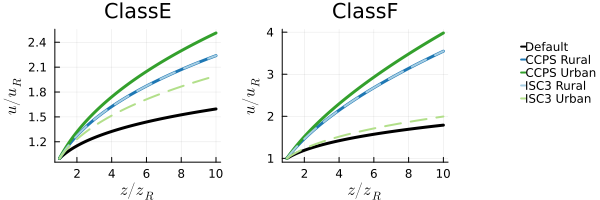

In [6]:
#| echo: false
#| label: fig-2
#| fig-cap: "Windspeed correlations for class E and F stability."

wsE, wsF = plot(), plot()

plot_windspeed!(wsE,ClassE)
plot_windspeed!(wsF,ClassF)

l2 = @layout [ grid(1,2) b{0.14w} ]

plot(wsE, wsF, ws_legend, layout=l2, size=(600,200), margin=2.5mm)

## Plume Dispersion

The more diverse sets of correlations are for the plume dispersion parameters, the crosswind and vertical dispersion. To some extent this is because the early @turner-1970 presented the dispersion parameters graphically and many subsequent authors generated their own curves to fit these plots.


### Crosswind Dispersion

Crosswind dispersion can be divided into the various attempts at fitting the curves presented graphically by Turner and those based on Briggs' urban and rural correlations[^fn]

[^fn]: @briggs-1973 page 38; Note that the correlations are given with respect to half-width/half-depth


The default correlation is a simple set of correlations of the form

$$ \sigma_y = a x^b $$

which attempts to fit the [Turner](#turner-1970) curves.

The CCPS correlations are from Briggs[@briggs-1973] and the ISC3 *urban* correlations are from Briggs as well, the ISC3 *rural* correlations are something else entirely but I suspect are intended to fit the Turner[@turner-1970] curves. The correlations from the TNO yellow book[@bakkum-2005] are also a different attempt at fitting the Turner curves. What `GasDispersion,jl` gives as "Turner" is the fit to the Turner curves given in Lees[@lees-1996].

In [7]:
#| echo: false

xs = range(1,1e5,1000)

function plot_cw!(plt,class)
    plot!(plt, xaxis=:log10, yaxis=:log10, xlabel=L"x", ylabel=L"\sigma_y", title="$class", legend=false)

    for s in sets
        ys = [ GasDispersion.crosswind_dispersion(x, Plume, class, s.eqn) for x in xs]
        plot!(plt, xs, ys, color=s.color, linestyle=s.linestyle, lw=s.lw, label=s.name)
    end
end

cw_legend = plot(framestyle=:none, legend=:topleft, foreground_color_legend = nothing);
for s in sets
    plot!(cw_legend,(1), color=s.color, linestyle=:solid, lw=2, label=s.name);
end

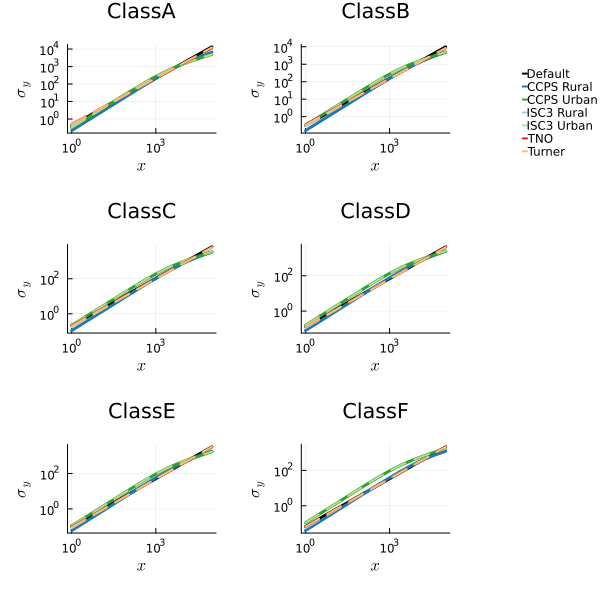

In [8]:
#| echo: false
#| label: fig-3
#| fig-cap: "Crosswind dispersion correlations."

cwA, cwB, cwC, cwD, cwE, cwF = plot(), plot(), plot(), plot(), plot(), plot()

plot_cw!(cwA,ClassA)
plot_cw!(cwB,ClassB)
plot_cw!(cwC,ClassC)
plot_cw!(cwD,ClassD)
plot_cw!(cwE,ClassE)
plot_cw!(cwF,ClassF)

l1 = @layout [ grid(3,2) b{0.14w} ]

plot(cwA, cwB, cwC, cwD, cwE, cwF, cw_legend, layout=l1, size=(600,600), margin=2.5mm)

Zooming in on the class F curves is illustrative of the lot: most of the lines overlap and hew pretty close to the curve-fit for Turner[@turner-1970] with the exception of the Briggs' urban/rural correlations. The biggest impact on these model parameters is whether or not a rural/urban terrain is used or not. *Note* these are log-log plots.

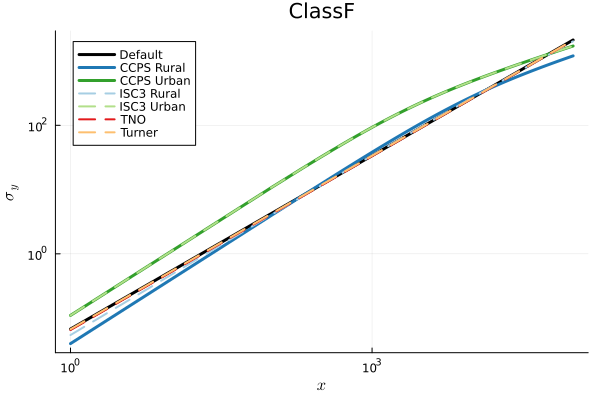

In [9]:
#| echo: false
#| label: fig-4
#| fig-cap: "Crosswind dispersion correlations, class F stability."

plot(cwF, legend=:topleft)

### Vertical Dispersion

The vertical dispersion correlations are decidedly more varied. Varied enough that I'm just going to show them all at full scale[^3]

[^3]: The correlations given in @ccps-1999 for urban conditions has typos in the class A, B and D correlations, I have corrected them here to match the Briggs correlations on which they are supposed to be based.

::: {#fig-5}

In [10]:
#| echo: false

using Logging

Logging.disable_logging(Logging.Warn);

In [11]:
#| echo: false

xs = range(1,1e5,1000)

function plot_vt!(plt,class)
    plot!(plt, xaxis=:log10, yaxis=:log10, xlabel=L"x", ylabel=L"\sigma", title="$class", legend=:topleft)

    for s in sets
        ys = [ GasDispersion.vertical_dispersion(x, Plume, class, s.eqn) for x in xs]
        plot!(plt, xs, ys, color=s.color, linestyle=s.linestyle, lw=s.lw, label=s.name)
    end
end;

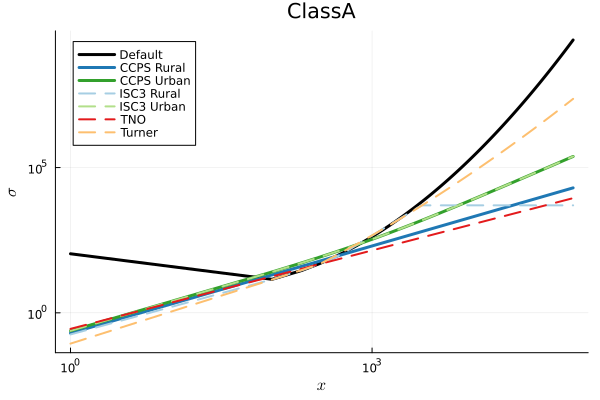

In [12]:
#| echo: false

vtA = plot()
plot_vt!(vtA,ClassA)
plot(vtA)

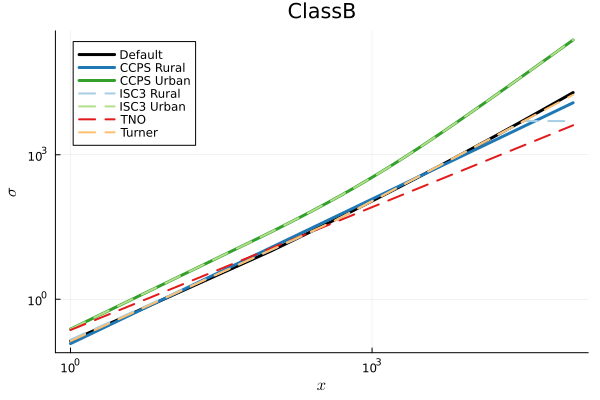

In [13]:
#| echo: false
vtB = plot()
plot_vt!(vtB,ClassB)
plot(vtB)

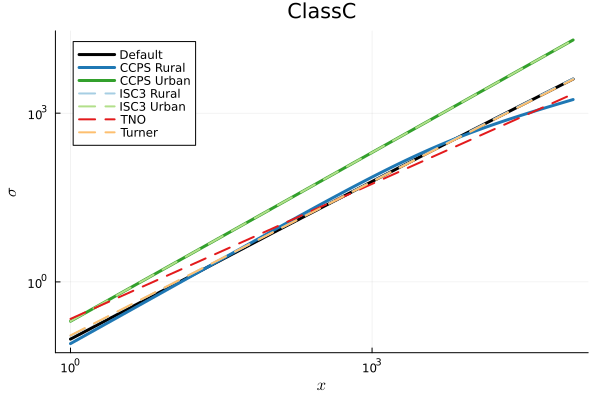

In [14]:
#| echo: false
vtC = plot()
plot_vt!(vtC,ClassC)
plot(vtC)

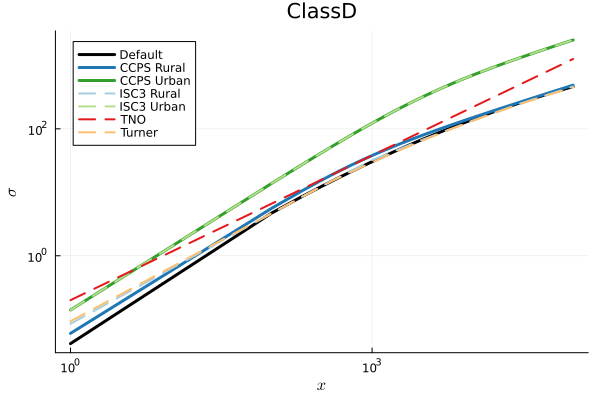

In [15]:
#| echo: false
vtD = plot()
plot_vt!(vtD,ClassD)
plot(vtD)

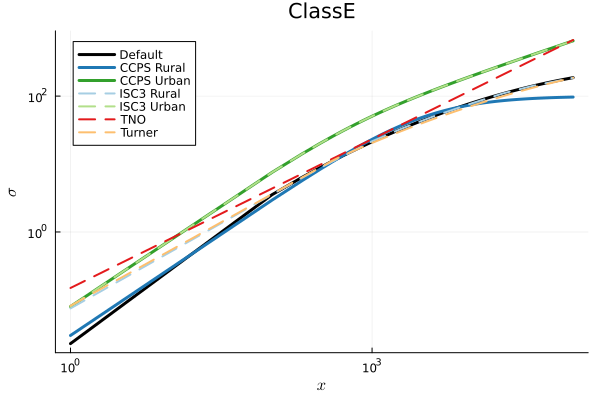

In [16]:
#| echo: false
vtE = plot()
plot_vt!(vtE,ClassE)
plot(vtE)

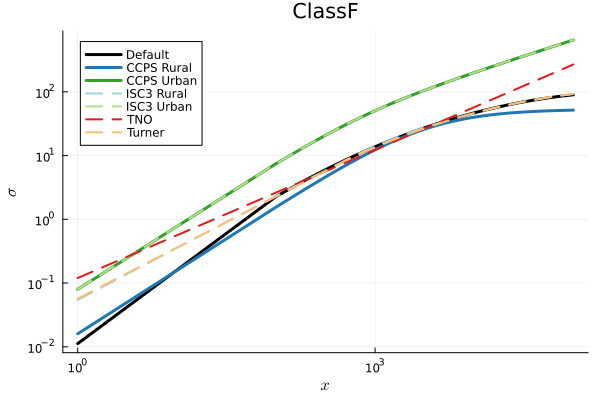

In [17]:
#| echo: false
vtF = plot()
plot_vt!(vtF,ClassF)
plot(vtF)

Vertical dispersion correlations.
:::

For some of these there is *an order of magnitude* spread in vertical dispersion, depending on which model happens to be used. Even when looking only at the correlations that are "universal", i.e. are not for either urban or rural terrains. From this alone one would expect that the concentration profiles would vary by a large amount, depending on which set of correlations one used to model a given scenario.

## An Example

Just to give an example of how this works out, lets look at the emissions from a large stack. I happened to have picked the stack for a large power plant in the Edmonton area: TransAlta's Sundance station. This power plant is on the shores of Lake Wabamun and is pretty rural, it has several stacks but let's consider only Stack 2 and examine the dispersion of SO<sub>2</sub> emissions.

From Alberta's [AEIR Air Emission Rates dataset](https://open.alberta.ca/opendata/aeirairemissionrates) we can pull the mass emission rates for SO<sub>2</sub> as well as the relevant stack dimensions. *Note* this dataset is from 2018 and thus may not represent the current operations at Sundance.

In [18]:
#| output: false
# TransAlta Sundance - Stack 2
m = 3200/3600 # mass emission rate: 3200kg/h in kg/s
h = 155.5 # stack height, m
d = 7.3   # stack diameter, m
v = 35.6  # stack exit velocity, m/s
T = 439.7 # stack exit temperature, K

439.7

For the sake of modeling let's assume a class D atmospheric stability with a windspeed at 10m of 2m/s. The atmosphere is otherwise at standard state.

In [19]:
#| output: false
# assumed weather conditions
uᵣ  = 2  # windspeed, m/s
zᵣ = 10 # windspeed elevation, m
stability = ClassD

# standard state
Pₛ = 101325 # Pa
Tₛ = 273.15 # K

273.15

We can construct the relevant scenario for `GasDispersion.jl` directly.

In [20]:
r = VerticalJet(m, Inf, d, v, h, Pₛ, T, 0.0)

a = SimpleAtmosphere(pressure=Pₛ, temperature=Tₛ, windspeed=uᵣ, windspeed_height=zᵣ, stability=stability)

# a dummy substance, since I know a gaussian plume doesn't require any material
# properties I have just left them as NaNs
SO2 = Substance(name=:SulfurDioxide,molar_weight=0.064066,liquid_density=1,boiling_temp=1,
                latent_heat=1,gas_heat_capacity=1,liquid_heat_capacity=1)

scn = Scenario(SO2,r,a)

Substance: SulfurDioxide 
    MW: 0.064066 kg/mol 
    P_v: GasDispersion.Antoine{Float64}(0.007705368698167287, 0.007705368698167287, 0.0) Pa 
    ρ_g: 2.7095140841291006 kg/m^3 
    ρ_l: 1 kg/m^3 
    T_ref: 288.15 K 
    P_ref: 101325.0 Pa 
    k: 1.4  
    T_b: 1.0 K 
    Δh_v: 1 J/kg 
    Cp_g: 1 J/kg/K 
    Cp_l: 1 J/kg/K 
VerticalJet release:
    ṁ: 0.8888888888888888 kg/s 
    Δt: Inf s 
    d: 7.3 m 
    u: 35.6 m/s 
    h: 155.5 m 
    P: 101325.0 Pa 
    T: 439.7 K 
    f_l: 0.0  
SimpleAtmosphere atmosphere:
    P: 101325.0 Pa 
    T: 273.15 K 
    u: 2.0 m/s 
    h: 10.0 m 
    rh: 0.0 % 
    stability: ClassD  


The Gaussian plume model is then given by the following, neglecting the effect of plume rise.

In [21]:
conc = plume(scn, GaussianPlume; plumerise=false);

Plotted below are the results for every equation set, at near ground level (at basically "my head" level). Clearly the urban/rural choice is quite important, leading to a ~4&times; greater maximum concentration. The TNO correlations, which uses the default correlation for windspeed and the TNO correlations for the crosswind and vertical dispersion, leads to less dispersion and thus a greater maximum concentration relative to the rest.

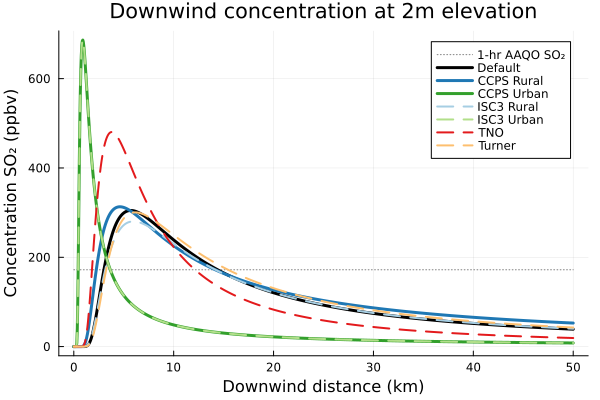

In [22]:
#| echo: false
#| label: fig-6
#| fig-cap: "Downwind concentration of sulfur dioxide, at 2m elevation, as predicted by the default, CCPS, ISC3, TNO, and Turner correlations, neglecting plume rise."

xs = range(1,5e4,1000)
kms = xs./1000

plt = plot()    
plot!(plt, xlabel="Downwind distance (km)", ylabel="Concentration SO₂ (ppbv)", title="Downwind concentration at 2m elevation", legend=:topright)
plot!(plt, [0, 50], [172, 172], color=:grey, linestyle=:dot, lw=1, label="1-hr AAQO SO₂")

for s in sets
    pl = plume(scn, GaussianPlume, s.eqn; plumerise=false)
    plot!(plt, kms, pl.(xs,0,2).*1e9, color=s.color, linestyle=s.linestyle, lw=s.lw, label=s.name)
end

plot(plt)

Plotted below is the 172ppbv isopleth, the 1-hr [Ambient Air Quality Objective (AAQO)](https://open.alberta.ca/publications/9781460134856) for SO<sub>2</sub> in Alberta. As we would expect, the correlations that lead to a higher maximum concentration correspond to less overall dispersion and the isopleth is quite a bit smaller for the urban versus rural case and the TNO versus the remaining cases. The scale is in kilometers so this is quite a large difference in area.

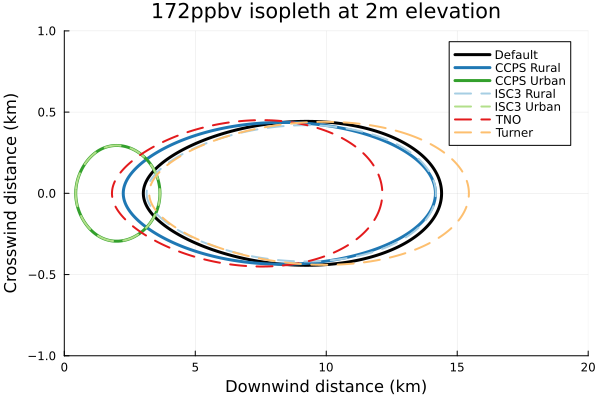

In [23]:
#| echo: false
#| label: fig-7
#| fig-cap: "Concentration isopleths for sulfur dioxide, at 2m elevation, as predicted by the default, CCPS, ISC3, TNO, and Turner correlations, neglecting plume rise."

using Contour

xs = range(1,2e4,1000)
ys = range(-2e3,2e3,1000)
c = 172e-9

plt = plot()    
plot!(plt, xlabel="Downwind distance (km)", ylabel="Crosswind distance (km)", title="172ppbv isopleth at 2m elevation", legend=:topright)

for s in sets
    pl = plume(scn, GaussianPlume, s.eqn; plumerise=false)
    pl_zs = [pl(xi,yi,2.0) for xi in xs, yi in ys]
    ctr = Contour.contour(xs,ys,pl_zs,c)
    pl_xs, pl_ys = coordinates(first(lines(ctr)))
    plot!(plt, pl_xs.*1e-3, pl_ys.*1e-3, color=s.color, linestyle=s.linestyle, lw=s.lw, label=s.name)
end

plot(plt, xlims=(0,20), ylims=(-1,1))

The above was assuming no plume rise, however the relative differences are much more pronounced when plume rise is included.

In [24]:
conc = plume(scn, GaussianPlume; plumerise=true);

Plotted below is the same downwind concentration plot as above, but incorporating the Briggs' plume rise model. Since this leads to a greater overall dispersion, the concentration is much smaller (everything is well below the AAQO at ground level, which is good news). However this adds another dimension along which the models can vary: plume rise is a function of windspeed, and overall dispersion is a function of plume rise. These different sets of correlations lead to the plume rising to a different elevation, and also dispersing to a differing degree, magnifying the differences between them. In this case there is up to a ~30&times; difference between the max concentrations predicted between the urban and rural case.

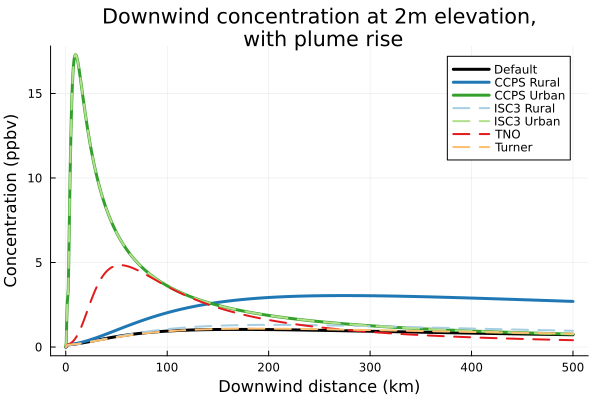

In [25]:
#| echo: false
#| label: fig-8
#| fig-cap: "Downwind concentration of sulfur dioxide, at 2m elevation, as predicted by the default, CCPS, ISC3, TNO, and Turner correlations, using Briggs' plume rise correlations."
xs = range(1,5e5,1000)
kms = xs./1000

plt = plot()    
plot!(plt, xlabel="Downwind distance (km)", ylabel="Concentration (ppbv)", title="Downwind concentration at 2m elevation,\n with plume rise", legend=:topright)

for s in sets
    pl = plume(scn, GaussianPlume, s.eqn; plumerise=true)
    plot!(plt, kms, pl.(xs,0,2).*1e9, color=s.color, linestyle=s.linestyle, lw=s.lw, label=s.name)
end

plot(plt)

## Final Thoughts

I think the above illustrates the necessity of picking a standard set of correlations for use when screening scenarios at a particular plant (e.g. using either the CCPS urban or rural correlations as appropriate for the area around the plant) and being careful to keep these consistent. It also shows how seriously one should take the exact values generated by the models: not very. The dispersion model results are highly sensitive to the choice of correlations, and they are also quite sensitive to the other assumptions that go into a release scenario (e.g. atmospheric stability, wind-speed, mass emission rate). The results are really order of magnitude at best.

It is often the case that chemical plants are situated at the periphery of cities, in areas that blur the line between "urban" and "rural". Also, cities grow and industrial areas fill in. A plant that was essentially rural may, overtime, fill in such that the urban correlations better represent the area. I think it is worth comparing the urban/rural models for a range of plausible results and considering whether assumptions made in the past about the area around the plant are still valid given changes in the area.

There are other correlations, for wind-speed and for dispersion, that take into account the local surface roughness which could be used instead and the sensitivity to the models to assumptions about surface roughness could be evaluated. This would likely lead to a smaller range of values, and give a path for updating the screening model as the area around the plant changes (update the assumed surface roughness and re-run).

## References
::: {#refs}
:::